# Transfer Learning - Bacteria & Virus (pediatric)

## resNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

### Step 2: Data Preparation

Define transformations to resize and normalize the images, and set up a dataset loader that reads from your labeled folders.

In [34]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch

# Define image transformations
# already applied data augmentation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),  # Crop to 224x224 pixels
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}


# Custom dataset to load images and assign labels
class PneumoniaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith(".jpeg")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Label images based on filename
        if "bacteria" in img_path:
            label = 0  # Bacterial pneumonia
        elif "virus" in img_path:
            label = 1  # Viral pneumonia
        else:
            raise ValueError("Unexpected filename format")

        if self.transform:
            image = self.transform(image)

        return image, label


# Define paths and create dataset
data_dir = "./Pneumonia2/mix/PNEUMONIA"  # Adjust this path if needed
full_dataset = PneumoniaDataset(data_dir)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Assign appropriate transformations for each dataset
train_dataset.dataset = PneumoniaDataset(data_dir, transform=data_transforms["train"])
val_dataset.dataset = PneumoniaDataset(data_dir, transform=data_transforms["val"])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Step 3: Define the Model with Pre-trained ResNet
We'll use a pre-trained ResNet (e.g., ResNet-18) and adjust the final layer to classify between bacterial and viral pneumonia.

In [35]:
# Load ResNet model and modify the last layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Bacterial and Viral

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Step 4: Set Up Loss Function and Optimizer
Use cross-entropy loss for classification and an optimizer like Adam.

In [40]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Step 5: Train the Model
Define a training loop to train and validate the model on the dataset.

In [41]:
import matplotlib.pyplot as plt

# Modified training function to track loss and accuracy for each epoch
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(
            f"Epoch {epoch+1}/{epochs}, "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
            f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accuracies, val_accuracies

### Step 6: Run Training
Start the training process and observe the results.

In [42]:
# Call the function and plot the results
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, epochs=10
)

Epoch 1/10, Train Loss: 0.5177, Train Acc: 0.7674, Test Loss: 0.4996, Test Acc: 0.7731
Epoch 2/10, Train Loss: 0.5094, Train Acc: 0.7718, Test Loss: 0.4973, Test Acc: 0.7754
Epoch 3/10, Train Loss: 0.5012, Train Acc: 0.7768, Test Loss: 0.4863, Test Acc: 0.7719
Epoch 4/10, Train Loss: 0.4980, Train Acc: 0.7730, Test Loss: 0.4853, Test Acc: 0.7813
Epoch 5/10, Train Loss: 0.4904, Train Acc: 0.7806, Test Loss: 0.4851, Test Acc: 0.7719
Epoch 6/10, Train Loss: 0.4901, Train Acc: 0.7829, Test Loss: 0.4761, Test Acc: 0.7825
Epoch 7/10, Train Loss: 0.4907, Train Acc: 0.7815, Test Loss: 0.4887, Test Acc: 0.7626
Epoch 8/10, Train Loss: 0.4713, Train Acc: 0.7870, Test Loss: 0.4794, Test Acc: 0.7789
Epoch 9/10, Train Loss: 0.4721, Train Acc: 0.7885, Test Loss: 0.4959, Test Acc: 0.7661
Epoch 10/10, Train Loss: 0.4806, Train Acc: 0.7838, Test Loss: 0.4763, Test Acc: 0.7801


### Step 7: Evaluate the Model + Visualize Results
After training, evaluate the model on the validation set and check the final accuracy.

Test Accuracy: 0.7801


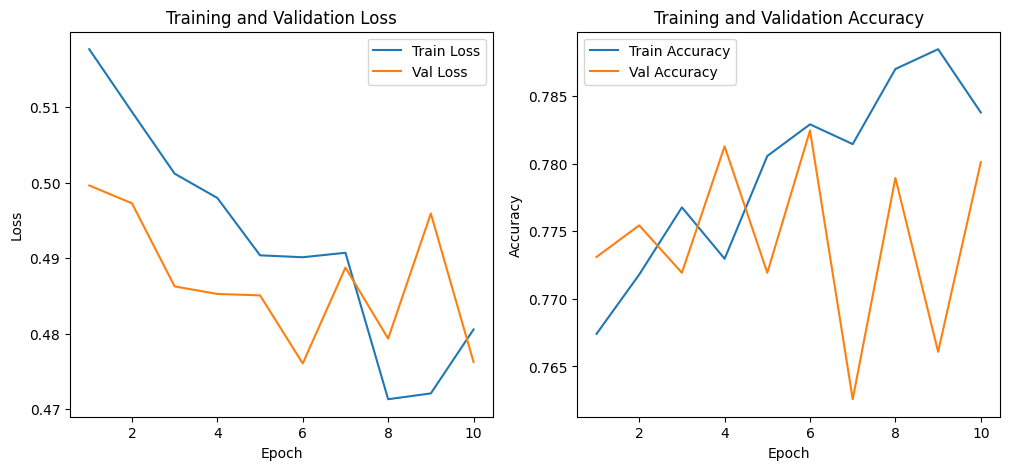

In [43]:
model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(val_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Plotting the loss and accuracy curves
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()

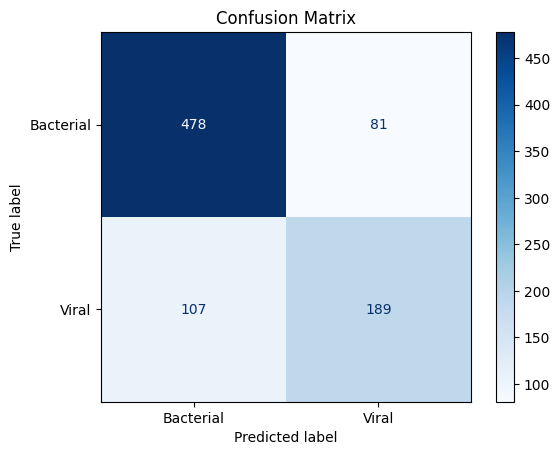

: 

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Gather true and predicted labels
all_labels = []
all_preds = []

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(
            device
        )  # Send to GPU if available
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Bacterial", "Viral"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Trial for Dummy Class

In [21]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet and modify for 3 classes
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: Bacterial, Viral, Dummy

# Define device and move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training code (from previous example) can be used here

C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\31234/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<0

Epoch 1/10
Train Loss: 0.6739 | Train Accuracy: 65.71%
Test Loss: 0.6848 | Test Accuracy: 72.16%
------------------------------
Epoch 2/10
Train Loss: 0.5714 | Train Accuracy: 72.94%
Test Loss: 0.6766 | Test Accuracy: 68.42%
------------------------------
Epoch 3/10
Train Loss: 0.5723 | Train Accuracy: 72.73%
Test Loss: 0.5426 | Test Accuracy: 75.67%
------------------------------
Epoch 4/10
Train Loss: 0.5586 | Train Accuracy: 73.64%
Test Loss: 0.5227 | Test Accuracy: 79.53%
------------------------------
Epoch 5/10
Train Loss: 0.5555 | Train Accuracy: 74.02%
Test Loss: 0.5051 | Test Accuracy: 78.13%
------------------------------
Epoch 6/10
Train Loss: 0.5297 | Train Accuracy: 75.37%
Test Loss: 0.4925 | Test Accuracy: 79.53%
------------------------------
Epoch 7/10
Train Loss: 0.5472 | Train Accuracy: 75.19%
Test Loss: 0.5711 | Test Accuracy: 70.76%
------------------------------
Epoch 8/10
Train Loss: 0.5346 | Train Accuracy: 75.78%
Test Loss: 0.5425 | Test Accuracy: 74.62%
-------

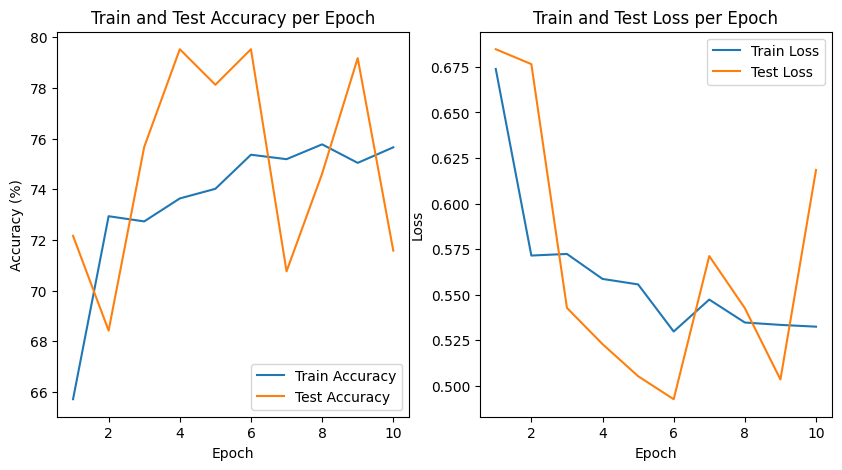

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load a pretrained ResNet model and modify the final layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: Bacterial, Viral, Dummy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy for each epoch
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop
epochs = 10  # Set the number of epochs
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= total_train
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= total_test
    test_accuracy = 100 * correct_test / total_test
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    # Print the progress for each epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("-" * 30)

# Plot accuracy and loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_accuracy_history, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_accuracy_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss_history, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()

plt.show()

### Confusion Matrix

Test Accuracy: 0.7158


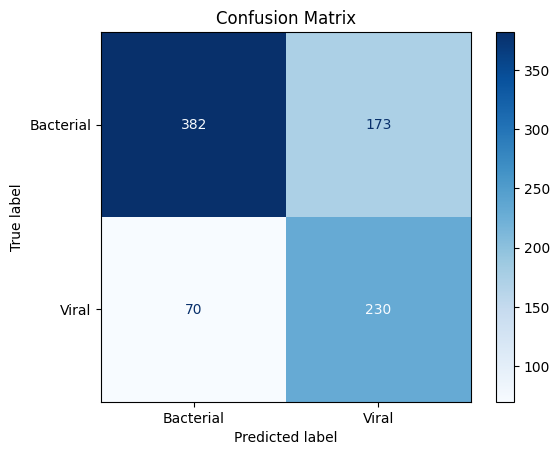

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(val_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Ensure model is in evaluation mode
model.eval()

# Gather true and predicted labels
all_labels = []
all_preds = []

# Evaluate the model on the validation set
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(
            device
        )  # Send to GPU if available
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Bacterial", "Viral"]
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()